## **Notebook #8 - Parte 2**
## Interpretability on convolutional neural networks when solving the MNIST classification problem.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**

### Installing the main packages
**Please, remember to execute [Restart runtime], as required.**

In [1]:
!pip install innvestigate
!pip install scipy==1.1.0
!pip install git+https://github.com/raghakot/keras-vis.git -U
!pip install 'h5py==2.10.0' --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 3.1 MB/s 
     |████████████████████████████████| 312 kB 42.3 MB/s 
     |████████████████████████████████| 50 kB 2.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.2.4 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 39.9 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninst

In [2]:
# Loading the main libraries
%tensorflow_version 1.x  # utiliza a versão 1.x já presente no Colab

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import innvestigate
import keras

from vis.visualization import visualize_activation
from vis.utils import utils


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # utiliza a versão 1.x já presente no Colab`. This will be interpreted as: `1.x`.


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


Using TensorFlow backend.


### Training the convolutional neural network for the classification task.

In [3]:
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train, x_test = x_train / 255.0, x_test / 255.0
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
activation='relu',input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
model.get_config()
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
evaluation = model.evaluate(x_test, y_test)

11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/5
60000/60000 [==============================] - 207s 3ms/step - loss: 0.1929 - accuracy: 0.9416
Epoch 2/5
60000/60000 [==============================] - 188s 3ms/step - loss: 0.0830 - accuracy: 0.9755
Epoch 3/5
60000/60000 [==============================] - 189s 3ms/step - loss: 0.0612 - accuracy: 0.9811
Epoch 4/5
60000/60000 [==============================] - 189s 3ms/step - loss: 0.0500 - accuracy: 0.9849
Epoch 5/5
10000/10000 [==============================] - 7s 692us/step


### Choosing *Total variation* and *L-p norm* weight coefficients

Since the output maximization method applies some types of regularization aiming at forcing the resulting images to behave reasonably like a database image, we need to determine their weights.

As done in the [link](https://github.com/raghakot/keras-vis/blob/master/examples/mnist/activation_maximization.ipynb), the weights are heuristically experimented until finding resulting images with satisfactory interpretability. Here, we apply a search procedure with the digit '9', varying each parameter between the values {0, 2.5, 5, 7.5, 10} (10 was a value chosen in the indicated link for one of the parameters). Thus, we present the following results.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


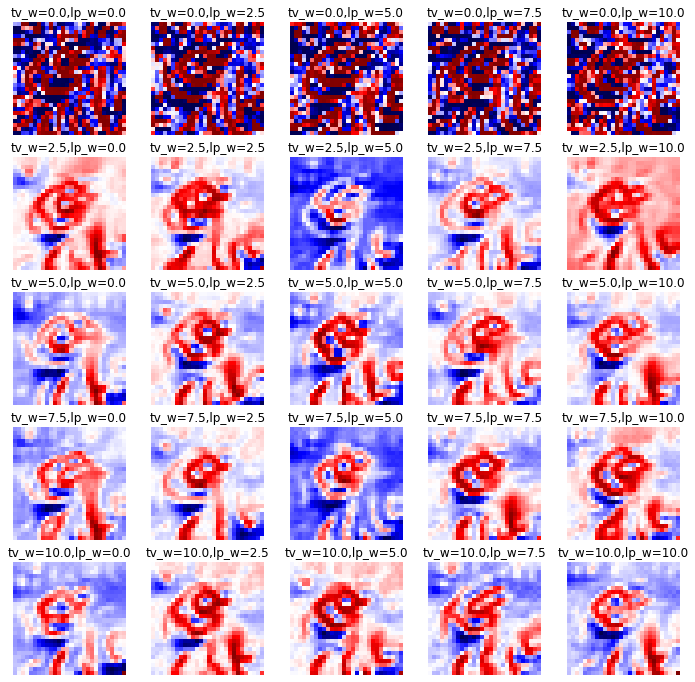

In [4]:
layer_idx = utils.find_layer_idx(model, 'dense_2')
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)
filter_idx = 9
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i in range(5):
  for j in range(5):
    img = visualize_activation(model, layer_idx,
    filter_indices=filter_idx, input_range=(0., 1.), verbose=False,
    max_iter=1000, tv_weight=2.5*i, lp_norm_weight=2.5*j)
    axs[i,j].imshow(img.squeeze(), cmap='seismic', interpolation='nearest')
    axs[i,j].set_title('tv_w='+str(2.5*i)+',lp_w='+str(2.5*j))
    axs[i,j].axis('off')

Several choices prove to be reasonably satisfactory. We choose the weight coefficient for *Total Variation* equal to 2.5 and for *L-p Norm* equal to 7.5, and execute the previous procedure for the 10 classes.

### Maximizing the output for each class.

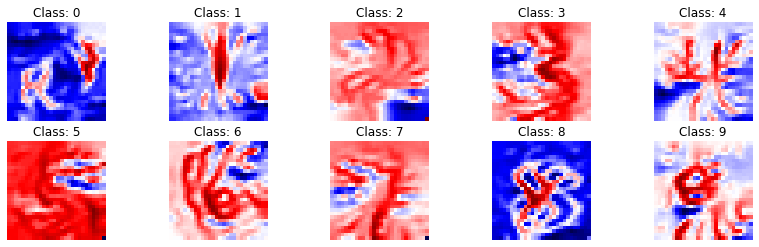

In [5]:
fig, axs = plt.subplots(2,5, figsize=(14, 4))
for i in range(2):
  for j in range(5):
    if(i*5+j)>9:
      break
    img = visualize_activation(model, layer_idx,
    filter_indices=i*5+j, input_range=(0., 1.), verbose=False,
    max_iter=1000, tv_weight=2.5, lp_norm_weight=7.5)
    axs[i,j].imshow(img.squeeze(), cmap='seismic', interpolation='nearest')
    axs[i,j].set_title('Class: '+str(i*5+j))
    axs[i,j].axis('off')

**(b)Notebook [Ativ8_LRP_MNIST_P2.ipynb]: Utilize a biblioteca keras-vis [2] para obter mapas de calor associados a uma resposta máxima para cada uma das 10
classes [3]. O próprio notebook busca valores adequados para os hiperparâmetros de ponderação Total variation e L-p norm. O que representam esses mapas de calor obtidos ao final da execução do notebook? Interprete os resultados.**

R: O mapa de calor apresentado é uma alucinação da rede para identificar os protótipos de cada classe, o objetivo nesse caso é verificar se os valores de *Total Variation* e *L-p Norm* são adequados para o cada classe, os valores selecionados foram 2,5 e 7,5, respectivamente. Podemos observar que esses valores são adequados para certas classes e ruins para outras, como por exemplo, as classe 8, 9, 4, 0 e 1 estão bem definidas, podemos identifcar com relativa fácilidade a estratégia adotada pelo classificador e o que ele considera como um protótipo para estes digitos.

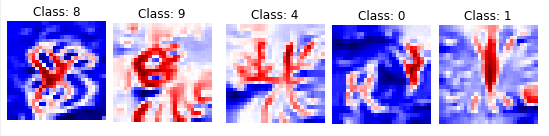

 Porém, para as outras classes esses valores não são tão interessantes, tomando como base a classe 5, podemos ver que o classificador considera mais (vermelho escuro) uma área que representa um digito 5, mas também considera praticamente toda a área externa como relevante, podemos dizer que neste caso o classificador não tem tanta certeza respeito da sua classificação, ele precisa de muitas informações para classificar um digito manuscrito 5 como tal, de maneira semelhante podemos observar esse mesmo comportamento na classes 2, 3, 7 e, um pouco mais suave, 6.

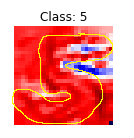

<small>*Foi destacado em amarelo a área que existe uma maior ativação*</small>

